In [2]:
import pandas as pd
from transformers import pipeline, AutoTokenizer
from prettytable import PrettyTable


In [3]:
with open('../0_data/statements.csv', 'r') as file:

    # headers = ['prompt', 'client', 'opt1', 'opt2', 'opt3', 'completion']
    df_generated = pd.read_csv(file, index_col=False)

df_generated.head()

,prompt,provider,temperature,top_p,max_tokens,statement,extremity_score
0,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,While the 2025 Trump administration's trade me...,-0.680280
1,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,In response to the 2025 Trump administration's...,-0.832605
2,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,"While we, as the European Union, respect the a...",-0.047196
3,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,"Thank you, Chair. In response to the 2025 Trum...",-0.546598
4,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,"Ladies and Gentlemen, in response to the 2025 ...",-0.759760


In [4]:
with open ('../0_data/final_labeled_dataset.csv', 'r') as file:
    df_original = pd.read_csv(file)

df_original.head()

,speaker_name,party,language,mep_id,role,text,alignment,orientation,translated,translated_text,label
0,Jean-Marc | Germain,S-D,FR,256901,au nom du groupe,"Monsieur le Président, mes chers collègues, Mo...",Center-Left,Left,True,"Mr. Chairman, dear colleagues, Commissioner, t...",-0.5
1,Julien | Sanchez,PfE,FR,88552,au nom du groupe,"Monsieur le Président, nous débattons aujourd'...",Right,Right,True,"Mr. Chairman, today we are debating the politi...",1.0
2,Bogdan | Rzońca,ECR,PL,197545,au nom du groupe,Panie Przewodniczący! Panie Komisarzu! Wydaje ...,Right,Right,True,"Mr. Chairman, Mr. Commissioner, the document i...",0.7
3,Rasmus | Nordqvist,Verts/ALE,EN,257044,au nom du groupe,"Mr President, thank you to the co-rapporteurs,...",Center-Left,Left,True,"Mr President, thank you to the co-rapporteurs,...",-0.7
4,João | Oliveira,The Left,PT,257083,au nom du groupe,"Senhor Presidente, as propostas que apresentám...",Left,Left,True,"Mr. President, the proposals that we have pres...",-1.0


In [5]:
MODEL = "classla/xlm-r-parlasent"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
def get_token_count(text):
    tokens = tokenizer(text, add_special_tokens=False)["input_ids"]
    return len(tokens)

df_original['token_count'] = df_original['text'].apply(get_token_count)
df_original['token_count'].describe()
# Calculate how many texts exceed the token limit (512 tokens)
over_limit_count = (df_original['token_count'] > 512).sum()
print(f"Number of texts exceeding 512 tokens: {over_limit_count} out of {len(df_original)} ({over_limit_count/len(df_original)*100:.2f}%)")

Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


Number of texts exceeding 512 tokens: 23 out of 684 (3.36%)


In [ ]:
from transformers import AutoModelForSequenceClassification, TextClassificationPipeline, AutoTokenizer, AutoConfig
import torch

# Initialize the model components
MODEL = "classla/xlm-r-parlasent"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Sweet piece of code to set the device to use hardware acceleration
if torch.cuda.is_available():
    device = 0  # CUDA
elif torch.backends.mps.is_available():
    device = 'mps'  # Apple Silicon
else:
    device = -1  # CPU

print(f"Using device: {device}")

# Using only the last 510 tokens of the text for sentiment analysis
def top_token(text):
    tokens = tokenizer(text, add_special_tokens=False)["input_ids"]
    last_tokens = tokens[-510:]  # Truncate to last 510
    input_ids = tokenizer.build_inputs_with_special_tokens(last_tokens)
    return tokenizer.decode(input_ids, skip_special_tokens=True)

# Create the pipeline with automatic device detection
sentiment_analysis = TextClassificationPipeline(
    model=model, 
    tokenizer=tokenizer, 
    return_all_scores=True,
    task='sentiment_analysis', 
    device=device,
    function_to_apply="none"
)

# Use reduced dataframes
# df_generated2 = df_generated.head(2).copy()
# df_original2 = df_original.head(2).copy()

# Apply sentiment analysis
df_generated['sentiment_bert'] = df_generated['statement'].apply(lambda x: sentiment_analysis(top_token(x))[0])
print('finished sentiment prediction for generated statements')

df_original['sentiment_bert'] = df_original['translated_text'].apply(lambda x: sentiment_analysis(top_token(x))[0])
print('finished sentiment prediction for original statements')


Device set to use mps


Using device: mps


/opt/anaconda3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# # SiBERT sentiment analysis

# tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
# def top_token(text):
#     tokens = tokenizer(text, add_special_tokens=False)["input_ids"]
#     last_tokens = tokens[-510:]  # Truncate to last 510
#     input_ids = tokenizer.build_inputs_with_special_tokens(last_tokens)
#     return tokenizer.decode(input_ids, skip_special_tokens=True)

# sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
# df_generated['sentiment_bert'] = df_generated['statement'].apply(lambda x: sentiment_analysis(top_token(x))[0])
# print('finished sentiment prediction for generated statements')
# df_original['sentiment_bert'] = df_original['translated_text'].apply(lambda x: sentiment_analysis(top_token(x))[0])
# print('finished sentiment prediction for original statements')

In [ ]:
df_generated

,prompt,provider,temperature,top_p,max_tokens,statement,extremity_score,sentiment_bert
0,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,While the 2025 Trump administration's trade me...,-0.680280,"[{'label': 'LABEL_0', 'score': 4.8054084777832..."
1,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,In response to the 2025 Trump administration's...,-0.832605,"[{'label': 'LABEL_0', 'score': 4.35161018371582}]"
2,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,"While we, as the European Union, respect the a...",-0.047196,"[{'label': 'LABEL_0', 'score': 3.2020692825317..."
3,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,"Thank you, Chair. In response to the 2025 Trum...",-0.546598,"[{'label': 'LABEL_0', 'score': 4.3896393775939..."
4,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,"Ladies and Gentlemen, in response to the 2025 ...",-0.759760,"[{'label': 'LABEL_0', 'score': 4.1227674484252..."
...,...,...,...,...,...,...,...,...
1995,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,"Ladies and Gentlemen, the recent trade measure...",-0.586082,"[{'label': 'LABEL_0', 'score': 4.0336823463439..."
1996,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,"Ladies and Gentlemen, as we find ourselves in ...",-0.690050,"[{'label': 'LABEL_0', 'score': 2.2678394317626..."
1997,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,"Ladies and Gentlemen, it is essential that we ...",-0.559931,"[{'label': 'LABEL_0', 'score': 1.7046427726745..."
1998,"[{'role': 'system', 'content': 'You are a EU p...",chatgpt,1,0.8,400,"Ladies and Gentlemen, the 2025 Trump administr...",-0.377260,"[{'label': 'LABEL_0', 'score': 3.1762995719909..."


In [ ]:
def extract_sentiment_parts(sentiment_data):
    """
    Extracts the sentiment label and score from the sentiment_bert column data.
    
    Args:
        sentiment_data: A dictionary containing 'label' and 'score' keys
        
    Returns:
        tuple: (label, score) with the extracted values
    """
    # Extract the first element from the list if it's a list
    if isinstance(sentiment_data, list):
        sentiment_data = sentiment_data[0]
        
    # Extract label and score
    label = sentiment_data.get('label', '')
    score = sentiment_data.get('score', 0.0)
    
    return label, score

# Apply the function to create new columns
df_generated['sentiment_label'] = df_generated['sentiment_bert'].apply(lambda x: extract_sentiment_parts(x)[0])
df_generated['sentiment_score'] = df_generated['sentiment_bert'].apply(lambda x: extract_sentiment_parts(x)[1])

df_original['sentiment_label'] = df_original['sentiment_bert'].apply(lambda x: extract_sentiment_parts(x)[0])
df_original['sentiment_score'] = df_original['sentiment_bert'].apply(lambda x: extract_sentiment_parts(x)[1])

# Display a sample of the results
print("Generated data sample:")
print(df_generated[['sentiment_label', 'sentiment_score']].head())

print("\nOriginal data sample:")
print(df_original[['sentiment_label', 'sentiment_score']].head())

Generated data sample:
  sentiment_label  sentiment_score
0         LABEL_0         4.805408
1         LABEL_0         4.351610
2         LABEL_0         3.202069
3         LABEL_0         4.389639
4         LABEL_0         4.122767

Original data sample:
  sentiment_label  sentiment_score
0         LABEL_0        -0.015592
1         LABEL_0         0.045495
2         LABEL_0         4.742831
3         LABEL_0         4.064230
4         LABEL_0         0.126493


In [ ]:
def get_descriptive_printout(sentiment_series):
    """Get descriptive statistics for a series of sentiment values"""
    # Calculate the statistics
    mean = sentiment_series.mean()
    std = sentiment_series.std()
    min_val = sentiment_series.min()
    max_val = sentiment_series.max()
    count = sentiment_series.count()
    
    # Return formatted values rounded to 2 decimal places
    return [
        round(mean, 2),
        round(std, 2),
        round(min_val, 2),
        round(max_val, 2),
        count
    ]

# Get sentiment statistics for original data
sentiment_original = get_descriptive_printout(df_original['sentiment_score'])

# Filter by provider
is_chatgpt = df_generated['provider'] == 'chatgpt'
is_deepseek = df_generated['provider'] == 'deepseek'

# Get statistics for each provider
sentiment_deepseek = get_descriptive_printout(df_generated[is_deepseek]['sentiment_score'])
sentiment_chatgpt = get_descriptive_printout(df_generated[is_chatgpt]['sentiment_score'])

# Create and format table
sentiment_table = PrettyTable()
sentiment_table.field_names = ['Source', 'Mean', 'Std Dev', 'Min', 'Max', 'Count']

sentiment_table.add_row(['Original', *sentiment_original])
sentiment_table.add_row(['ChatGPT', *sentiment_chatgpt])
sentiment_table.add_row(['DeepSeek', *sentiment_deepseek])

# Print table
print('Sentiment Analysis Results:')
print(sentiment_table)


Sentiment Analysis Results:
+----------+------+---------+-------+------+-------+
|  Source  | Mean | Std Dev |  Min  | Max  | Count |
+----------+------+---------+-------+------+-------+
| Original | 1.02 |   1.51  | -0.15 | 4.92 |  374  |
| ChatGPT  | 3.51 |   1.14  | -0.05 | 5.01 |  1000 |
| DeepSeek | 4.34 |   0.28  |  2.34 | 4.81 |  1000 |
+----------+------+---------+-------+------+-------+


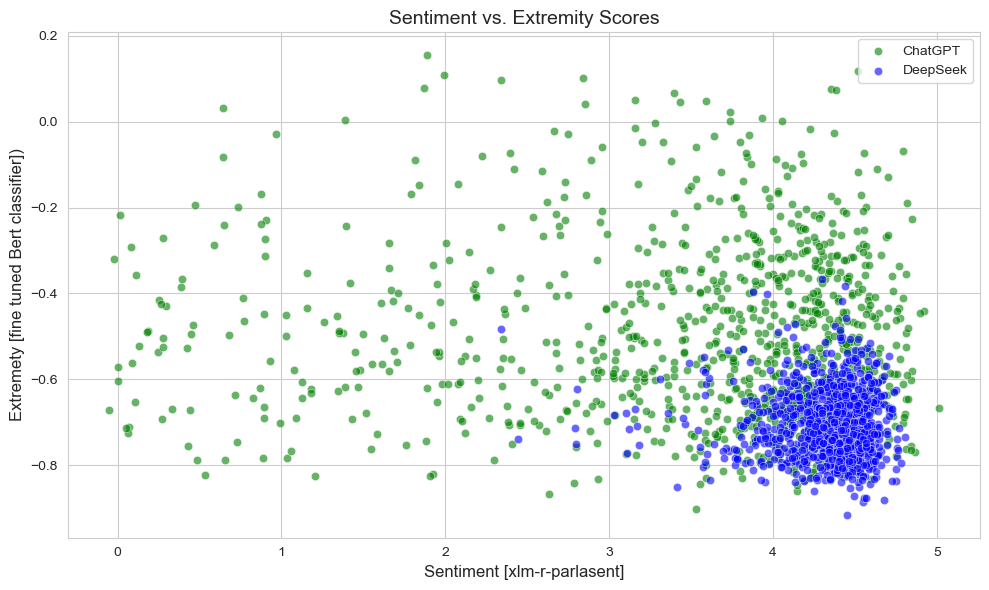

In [ ]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create scatter plots
# sns.scatterplot(x='sentiment_score', y='extremity_score', data=df_original, 
#                 alpha=0.6, label='Original', color='red')

sns.scatterplot(x='sentiment_score', y='extremity_score', data=df_generated[is_chatgpt], 
                alpha=0.6, label='ChatGPT', color='green')

sns.scatterplot(x='sentiment_score', y='extremity_score', data=df_generated[is_deepseek], 
                alpha=0.6, label='DeepSeek', color='blue')

# Add labels and title
plt.xlabel('Sentiment [xlm-r-parlasent]', fontsize=12)
plt.ylabel('Extremety [fine tuned Bert classifier])', fontsize=12)
plt.title('Sentiment vs. Extremity Scores', fontsize=14)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()